# Parcial – Modelización y Simulaciones (CC2017)

Notebook  con los incisos **(d)**, **(e)** y **(f)**.  
Cumple:
- Bootstrapping con **Transformada Inversa** (discreta) sobre 10 valores
- 5 rangos (bins) uniformes, **PMF** y **CDF**
- **Aceptación–Rechazo** con **GCLM** hacia la distribución simplificada

**Datos del enunciado**:
- Dataset: `[7, 6, 7, 6, 5, 5, 1, 5, 1, 7]`
- Probabilidades: `[0.19, 0.15, 0.08, 0.10, 0.08, 0.04, 0.04, 0.05, 0.01, 0.26]`


In [3]:
# =========================
# CONFIG (editar aquí)
# =========================
OUTDIR = "./out"           # Carpeta de salida

# (d) Bootstrapping
N_BOOT = 10_000

# (e) Rangos
K_BINS = 5
USE_PRECOMPUTED_MEANS = True   # Usa OUTDIR/means.npy si existe; si no, recalcula (d)

# (f) Aceptación–Rechazo
N_ACCEPT = 10_000
SEED = 13579
USE_PRECOMPUTED_BINS = True    # Usa archivos de (e) si existen; si no, recalcula (d) y (e)

# Qué ejecutar (puedes desactivar alguno si presentas por partes)
RUN_D = True
RUN_E = True
RUN_F = True

In [4]:
# =========================
# Importaciones y setup
# =========================
import os
from math import floor
import numpy as np
import pandas as pd

# Backend no interactivo para que también funcione al exportar
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

def ensure_dir(path: str):
    os.makedirs(path, exist_ok=True)
ensure_dir(OUTDIR)
print("Creado/uso de carpeta:", os.path.abspath(OUTDIR))

Creado/uso de carpeta: d:\UVG\Modsim\Parcial1\out


## (a) y (b) – Datos base
Se normalizan probabilidades por seguridad ante redondeos.

In [5]:
DATA = np.array([7, 6, 7, 6, 5, 5, 1, 5, 1, 7], dtype=float)
PROBS = np.array([0.19, 0.15, 0.08, 0.10, 0.08, 0.04, 0.04, 0.05, 0.01, 0.26], dtype=float)
PROBS = PROBS / PROBS.sum()
print("Media original:", DATA.mean())
print("Suma PROBS:", PROBS.sum())

Media original: 5.0
Suma PROBS: 1.0


## Utilidades (Transformada Inversa y GCLM)
Implementaciones simples y claras para reutilizar en (d), (e) y (f).

In [6]:
def inverse_transform_sample(u: np.ndarray, values: np.ndarray, cdf: np.ndarray) -> np.ndarray:
    """Transformada inversa discreta para mapear U(0,1) -> valores discretos."""
    idx = np.searchsorted(cdf, u, side="left")
    return values[idx]

class LCGMixed:
    """Generador Congruencial Lineal Mixto (constantes C/ANSI)."""
    def __init__(self, seed: int, a: int=1103515245, c: int=12345, m: int=2**31):
        self.a = a
        self.c = c
        self.m = m
        self.state = seed % m
    def rand_uint(self) -> int:
        self.state = (self.a * self.state + self.c) % self.m
        return self.state
    def rand(self) -> float:
        return self.rand_uint() / self.m

## (d) Bootstrapping con Transformada Inversa
1. Centro los datos restando la media (offset).  
2. Genero \(U \sim U(0,1)\) y uso **Transformada Inversa** sobre la CDF discreta (10 valores).  
3. Repite N veces y guarda la **media** de cada muestra.

Al final: histograma de medias y desviación estándar de esa distribución.

In [7]:
def run_bootstrap(N: int, outdir: str):
    ensure_dir(outdir)
    mean_original = DATA.mean()
    offset_data = DATA - mean_original
    cdf = np.cumsum(PROBS)

    n = len(DATA)
    U = np.random.rand(N, n)
    samples = inverse_transform_sample(U, offset_data, cdf)
    means = samples.mean(axis=1)

    # STD de la distribución de medias
    std_muestral = means.std(ddof=1)
    std_poblacional = means.std(ddof=0)

    # Histograma (una sola figura)
    plt.figure()
    plt.hist(means, bins=30, density=True)
    plt.title("Distribución de medias (Bootstrapping con Transformada Inversa)")
    plt.xlabel("Media de la muestra (offset)")
    plt.ylabel("Densidad")
    plt.tight_layout()
    plt.savefig(os.path.join(outdir, "hist_bootstrap_means.png"), dpi=160)
    plt.show()
    plt.close()

    # Guardar medios
    np.save(os.path.join(outdir, "means.npy"), means)

    # Resumen CSV
    resumen = pd.DataFrame({
        "Métrica": [
            "Media original (datos)",
            "Media offset (≈0)",
            "STD medias (muestral)",
            "STD medias (poblacional)",
            "Min medias",
            "Max medias"
        ],
        "Valor": [
            float(mean_original),
            float(offset_data.mean()),
            float(std_muestral),
            float(std_poblacional),
            float(means.min()),
            float(means.max())
        ]
    })
    resumen.to_csv(os.path.join(outdir, "bootstrap_resumen.csv"), index=False)

    print("== (d) Bootstrap ==")
    print(f"Media original: {mean_original:.6f}")
    print(f"STD (muestral) de medias: {std_muestral:.6f}")
    print(f"STD (poblacional) de medias: {std_poblacional:.6f}")
    print(f"Rango de medias: [{means.min():.6f}, {means.max():.6f}]")
    return means

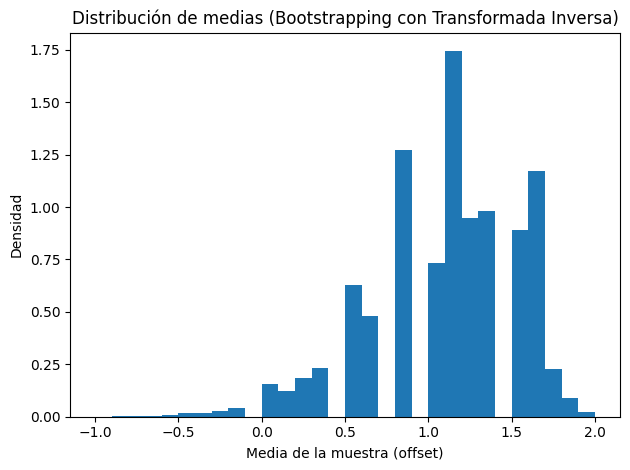

== (d) Bootstrap ==
Media original: 5.000000
STD (muestral) de medias: 0.436413
STD (poblacional) de medias: 0.436392
Rango de medias: [-1.000000, 2.000000]


In [8]:
means = None
means_path = os.path.join(OUTDIR, "means.npy")
if RUN_D:
    means = run_bootstrap(N_BOOT, OUTDIR)
elif USE_PRECOMPUTED_MEANS and os.path.exists(means_path):
    means = np.load(means_path)
else:
    means = run_bootstrap(N_BOOT, OUTDIR)

## (e) Rangos, PMF y CDF de la distribución de medias
Divide \[min, max] en `K_BINS` intervalos iguales; obtiene probabilidades por bin y construye PMF/CDF.

In [9]:
def build_bins_from_means(means: np.ndarray, k: int, outdir: str):
    ensure_dir(outdir)
    min_m, max_m = means.min(), means.max()
    edges = np.linspace(min_m, max_m, k + 1)
    counts, _ = np.histogram(means, bins=edges)
    probs_bins = counts / counts.sum()
    midpoints = 0.5 * (edges[:-1] + edges[1:])

    # Tabla CSV
    labels = []
    for i in range(k):
        left, right = edges[i], edges[i+1]
        label = f"[{left:.6f}, {right:.6f})" if i < k-1 else f"[{left:.6f}, {right:.6f}]"
        labels.append(label)
    df = pd.DataFrame({"Bin": labels, "Midpoint": midpoints, "Probability": probs_bins})
    df.to_csv(os.path.join(outdir, f"probabilidades_por_bin_k{k}.csv"), index=False)

    # PMF y CDF
    order = np.argsort(midpoints)
    x = midpoints[order]; pmf = probs_bins[order]; cdf = np.cumsum(pmf)

    # PMF
    plt.figure()
    width = (x.max() - x.min()) / (2 * k) if x.max() > x.min() else 0.1
    plt.bar(x, pmf, width=width)
    plt.title(f"PMF – Distribución simplificada ({k} puntos)")
    plt.xlabel("x (midpoint de bin)")
    plt.ylabel("Probabilidad")
    plt.tight_layout()
    plt.savefig(os.path.join(outdir, f"pmf_simplificada_k{k}.png"), dpi=160)
    plt.close()

    # CDF
    plt.figure()
    plt.step(x, cdf, where="post")
    plt.title(f"CDF – Distribución simplificada ({k} puntos)")
    plt.xlabel("x (midpoint de bin)")
    plt.ylabel("F(x)")
    plt.ylim(0, 1.05)
    plt.tight_layout()
    plt.savefig(os.path.join(outdir, f"cdf_simplificada_k{k}.png"), dpi=160)
    plt.close()

    # Guardar para (f)
    np.save(os.path.join(outdir, f"edges_k{k}.npy"), edges)
    np.save(os.path.join(outdir, f"probs_bins_k{k}.npy"), probs_bins)

    # Print resumen
    print("== (e) Bins/PMF/CDF ==")
    for i in range(k):
        left, right = edges[i], edges[i+1]
        label = f"[{left:.6f}, {right:.6f})" if i < k-1 else f"[{left:.6f}, {right:.6f}]"
        print(f"{label}  midpoint={midpoints[i]:.6f}  p={probs_bins[i]:.6f}")
    return probs_bins, edges

In [10]:
edges_path = os.path.join(OUTDIR, f"edges_k{K_BINS}.npy")
probs_path = os.path.join(OUTDIR, f"probs_bins_k{K_BINS}.npy")
probs_bins, edges = None, None
if RUN_E:
    probs_bins, edges = build_bins_from_means(means, K_BINS, OUTDIR)
elif USE_PRECOMPUTED_BINS and os.path.exists(edges_path) and os.path.exists(probs_path):
    edges = np.load(edges_path); probs_bins = np.load(probs_path)
else:
    probs_bins, edges = build_bins_from_means(means, K_BINS, OUTDIR)

== (e) Bins/PMF/CDF ==
[-1.000000, -0.400000)  midpoint=-0.700000  p=0.002600
[-0.400000, 0.200000)  midpoint=-0.100000  p=0.025100
[0.200000, 0.800000)  midpoint=0.500000  p=0.164800
[0.800000, 1.400000)  midpoint=1.100000  p=0.469200
[1.400000, 2.000000]  midpoint=1.700000  p=0.338300


## (f) Aceptación–Rechazo con GCLM
Propuesta uniforme en los `K_BINS` y objetivo con probabilidades `p_i` (de (e)).  
Constante de rechazo: \(c = \max_i p_i / g(i) = K\_BINS \cdot \max p_i\).

In [11]:
def acceptance_rejection_from_bins(N_accept: int, probs_bins: np.ndarray, edges: np.ndarray, seed: int, outdir: str):
    ensure_dir(outdir)
    k = len(probs_bins)
    rng = LCGMixed(seed=seed)

    p = probs_bins.astype(float)
    p = p / p.sum() if p.sum() != 1 else p
    g = np.full_like(p, 1.0 / k)
    c_AR = float((p / g).max())
    max_p = float(p.max())

    accepted, trials = [], 0
    while len(accepted) < N_accept:
        trials += 1
        u1 = rng.rand()
        idx = int(floor(u1 * k))
        if idx == k:
            idx = k - 1
        u2 = rng.rand()
        if u2 < (p[idx] / max_p):
            u3 = rng.rand()
            val = edges[idx] + u3 * (edges[idx+1] - edges[idx])
            accepted.append(val)

    samples = np.array(accepted, dtype=float)
    accept_rate = len(samples) / trials

    # Histograma A&R
    plt.figure()
    plt.hist(samples, bins=30, density=True)
    plt.title("A&R con GCLM – Aproximación a la distribución de medias (simplificada)")
    plt.xlabel("Valor simulado")
    plt.ylabel("Densidad")
    plt.tight_layout()
    plt.savefig(os.path.join(outdir, "hist_ar_simplified.png"), dpi=160)
    plt.show()
    plt.close()

    # PMF/CDF de la distribución simplificada
    midpoints = 0.5 * (edges[:-1] + edges[1:])
    order = np.argsort(midpoints)
    x = midpoints[order]; pmf = p[order]; cdf = np.cumsum(pmf)

    # PMF
    plt.figure()
    width = (x.max() - x.min()) / (2 * k) if x.max() > x.min() else 0.1
    plt.bar(x, pmf, width=width)
    plt.title(f"PMF – Distribución simplificada ({k} puntos)")
    plt.xlabel("x (midpoint de bin)")
    plt.ylabel("Probabilidad")
    plt.tight_layout()
    plt.savefig(os.path.join(outdir, f"pmf_simplificada_k{k}_f.png"), dpi=160)
    plt.show()
    plt.close()

    # CDF
    plt.figure()
    plt.step(x, cdf, where="post")
    plt.title(f"CDF – Distribución simplificada ({k} puntos)")
    plt.xlabel("x (midpoint de bin)")
    plt.ylabel("F(x)")
    plt.ylim(0, 1.05)
    plt.tight_layout()
    plt.savefig(os.path.join(outdir, f"cdf_simplificada_k{k}_f.png"), dpi=160)
    plt.show()
    plt.close()

    # Métricas CSV
    metrics = pd.DataFrame({
        "Métrica": ["c (A&R)", "max p_i", "tasa aceptación", "N aceptados", "ensayos totales"],
        "Valor": [c_AR, max_p, accept_rate, int(len(samples)), int(trials)]
    })
    metrics.to_csv(os.path.join(outdir, "ar_metricas.csv"), index=False)

    # Ecuación del GCLM y constantes
    with open(os.path.join(outdir, "gclm_ecuacion.txt"), "w", encoding="utf-8") as f:
        f.write("X_{n+1} = (a X_n + c) mod m;  U_n = X_n / m\n")
        f.write("Constantes usadas: m=2^31, a=1103515245, c=12345\n")

    print("== (f) Aceptación–Rechazo ==")
    print(f"c (A&R): {c_AR:.6f}   max p_i: {max_p:.6f}   tasa aceptación: {accept_rate:.6f}")

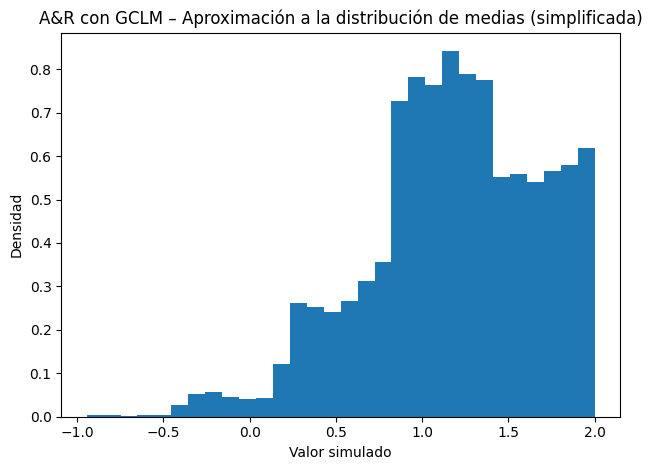

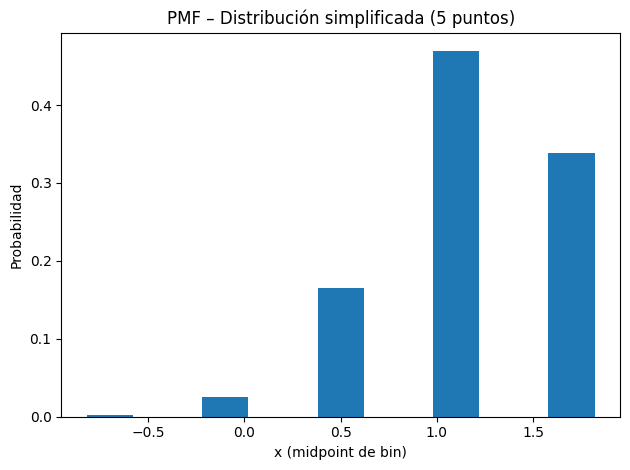

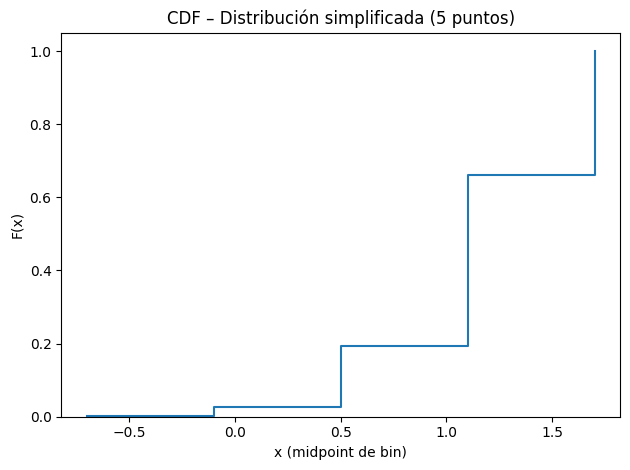

== (f) Aceptación–Rechazo ==
c (A&R): 2.346000   max p_i: 0.469200   tasa aceptación: 0.425713
Listo. Revisa la carpeta: d:\UVG\Modsim\Parcial1\out


In [12]:
if RUN_F:
    acceptance_rejection_from_bins(N_ACCEPT, probs_bins, edges, SEED, OUTDIR)
print("Listo. Revisa la carpeta:", os.path.abspath(OUTDIR))

---
**Notas:**
- Las figuras y CSVs quedan en `OUTDIR`.
- Cumple con una figura por gráfico
- Cambiar solo la celda **CONFIG** para repetir el análisis.